
Title: Image classification from scratch
Author: Pi
Date created: 12 March 2021
Description: Training an image classifier from to detect cracks on concrete walls.


In [ ]:
## Setup

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Filter out corrupted images from the training data

import os

num_skipped = 0
for folder_name in ("Negative", "Positive"):
    folder_path = os.path.join("Data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [ ]:
## Generate dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

In [ ]:
# Visualizing the data
# The images labelled 1 contains crack 
# and the ones labelled 0 are smooth
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Introduce diversity into the image dataset by rotating some of the images
    
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [ ]:
# Let's visualizing the augmented samples

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Configure dataset for performance

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [ ]:
## Build a model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Train the model with 2 epochs for temporary results

epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [ ]:
# save model and architecture to single file
model.save("wallcrackdetection.h5")
print("Saved model to disk")

crack : [97.61986] splitted/2_0.jpeg
crack : [98.34983] splitted/3_0.jpeg
crack : [95.95238] splitted/4_0.jpeg
crack : [99.99754] splitted/5_0.jpeg
crack : [99.99996] splitted/6_0.jpeg
crack : [100.] splitted/7_0.jpeg
crack : [100.] splitted/8_0.jpeg
crack : [81.64234] splitted/9_0.jpeg
crack : [87.98673] splitted/10_0.jpeg
crack : [80.8019] splitted/13_0.jpeg
crack : [94.62056] splitted/14_0.jpeg
crack : [81.941154] splitted/15_0.jpeg
crack : [95.90109] splitted/0_1.jpeg
crack : [96.81943] splitted/1_1.jpeg
crack : [93.76053] splitted/2_1.jpeg
crack : [95.50487] splitted/3_1.jpeg
crack : [99.59181] splitted/5_1.jpeg
crack : [99.93793] splitted/6_1.jpeg
crack : [100.] splitted/7_1.jpeg
crack : [99.91423] splitted/8_1.jpeg
crack : [99.965324] splitted/10_1.jpeg
crack : [99.02007] splitted/13_1.jpeg
crack : [81.46229] splitted/14_1.jpeg
crack : [99.34898] splitted/15_1.jpeg
crack : [86.27101] splitted/0_2.jpeg
crack : [99.68688] splitted/1_2.jpeg
crack : [99.85377] splitted/2_2.jpeg
crac

TypeError: expected str, bytes or os.PathLike object, not builtin_function_or_method

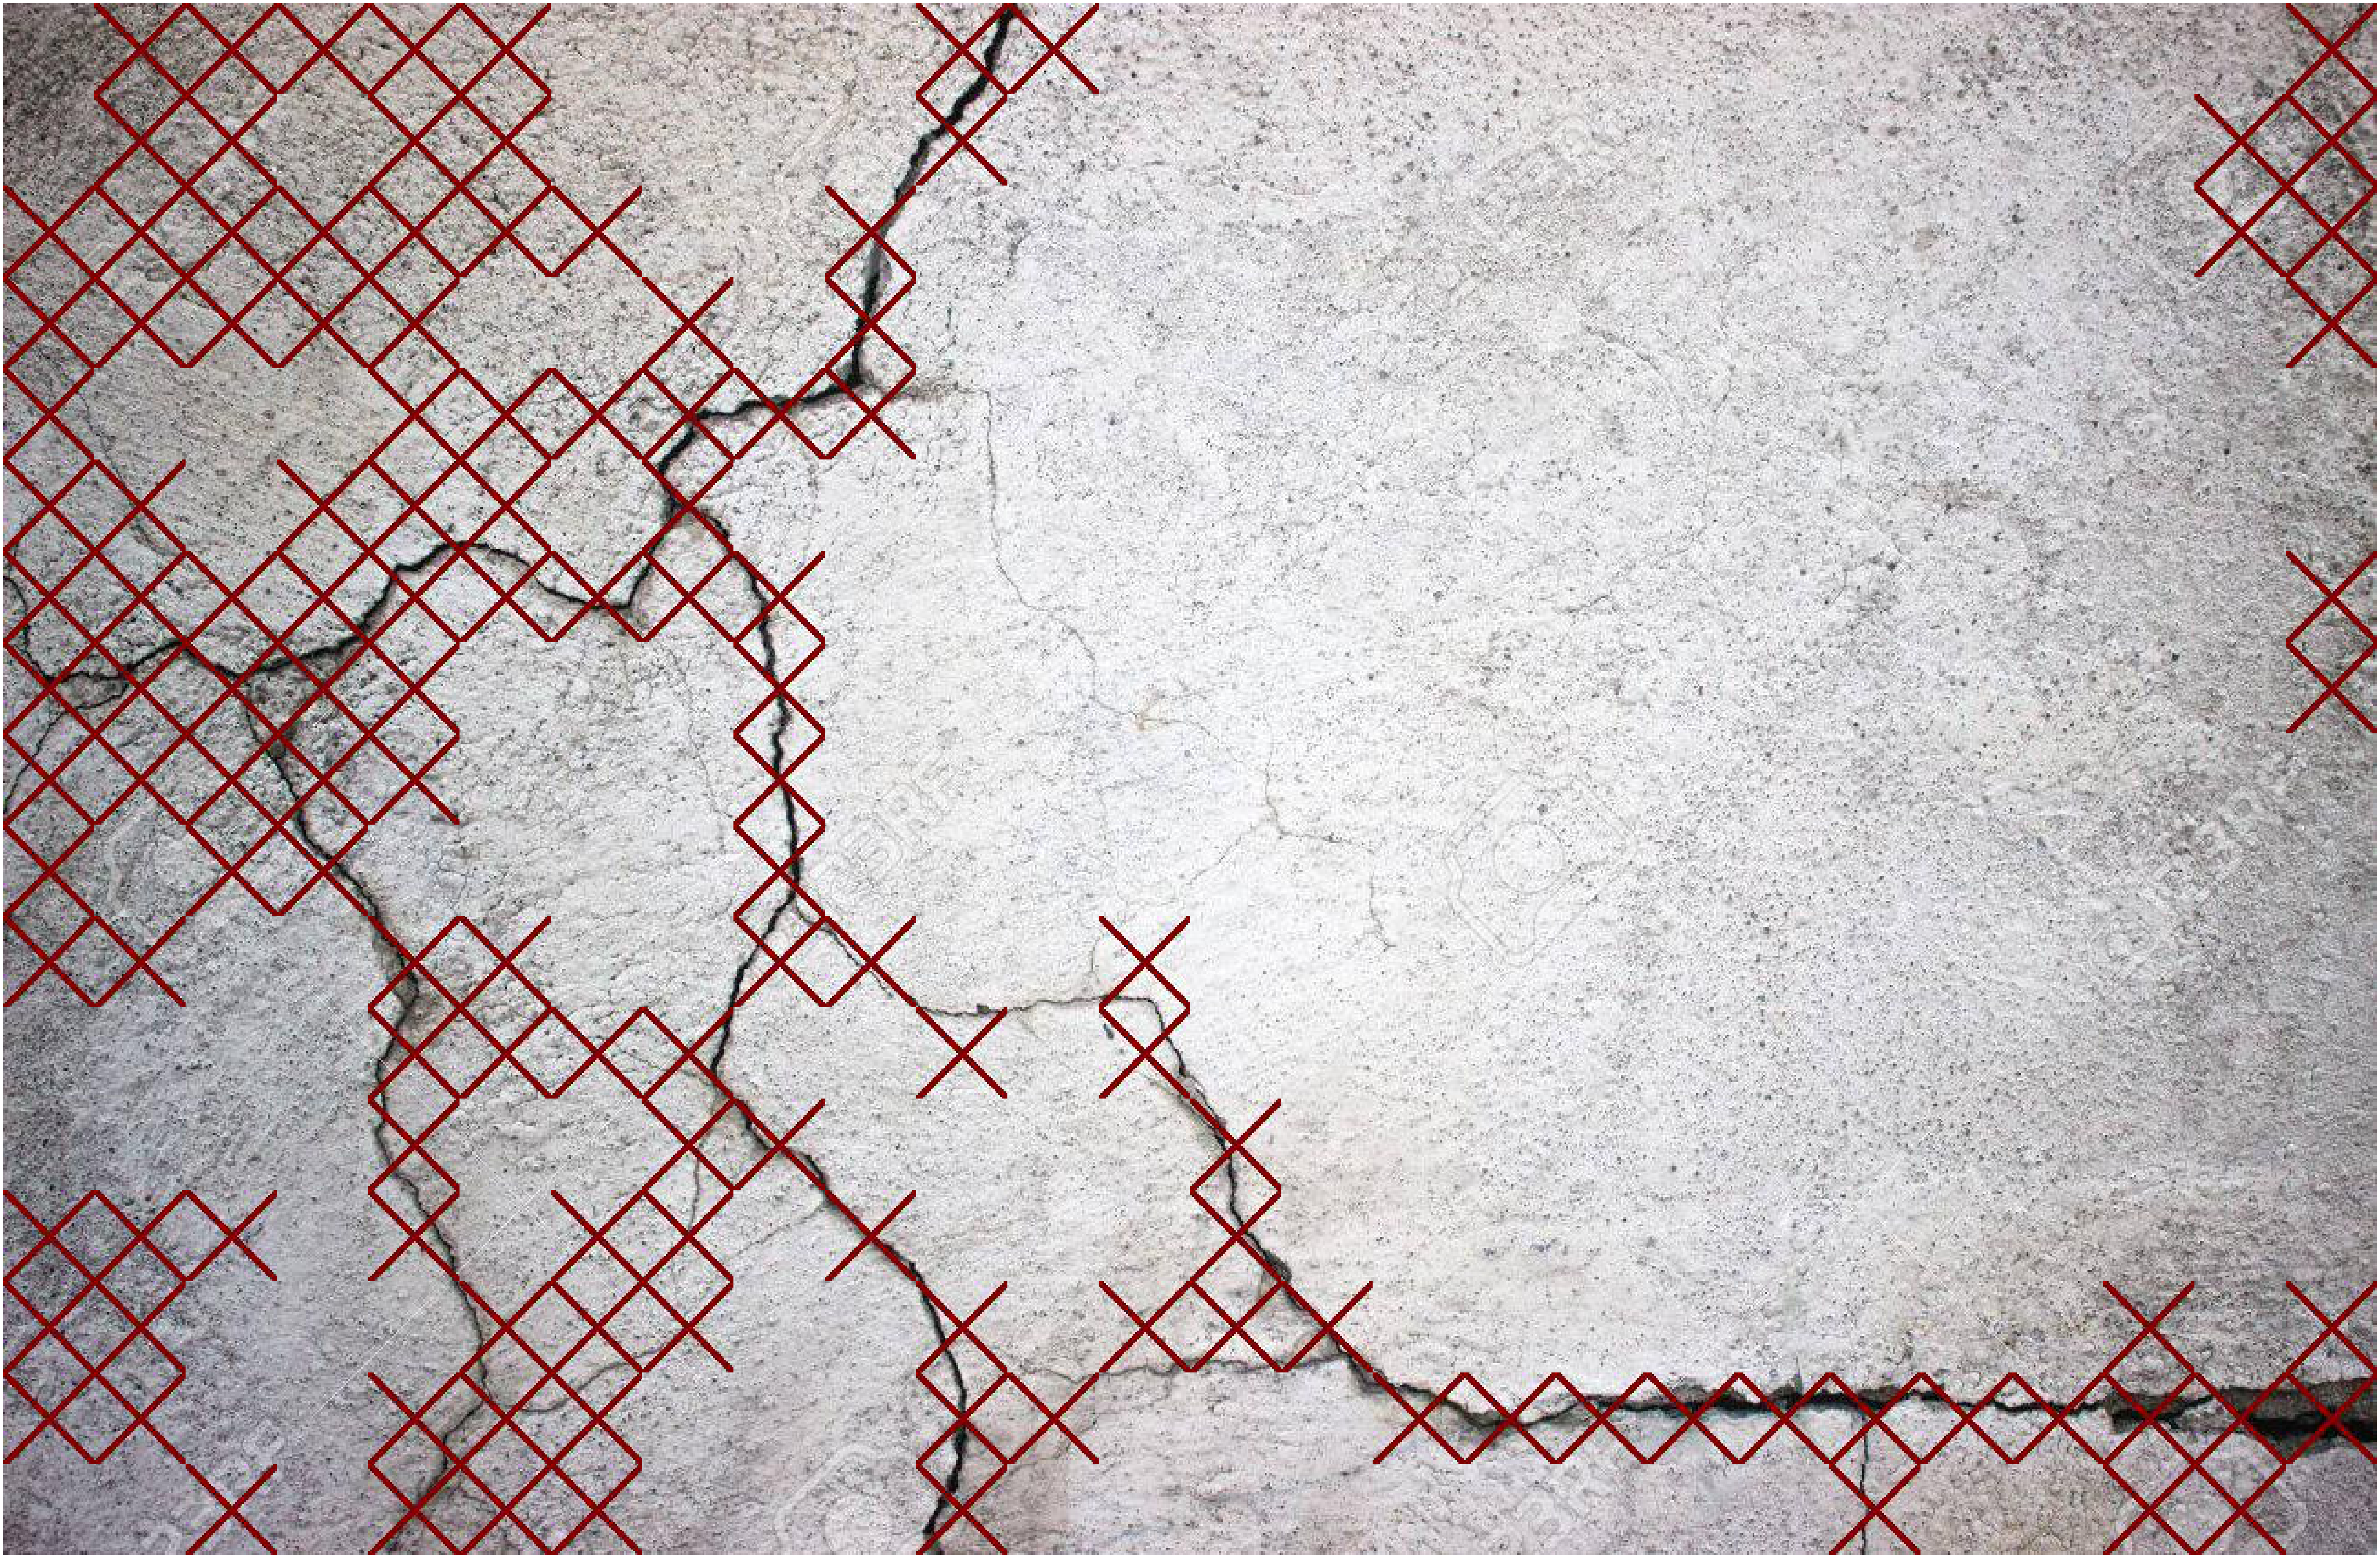

In [85]:
# Image Analysis

filename_to_analyze = "test.jpeg"

from PIL import Image, ImageDraw

from itertools import product
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import math
import matplotlib.pyplot as plt


def tile(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join(dir_out, f'{int(i/d)}_{int(j/d)}{ext}')
        img.crop(box).save(out)
        # i is vertical column count
        # j is horizontal row count
        row = int(j/d)
        column = int(j/d)
        
    
tile_resolution = 50

tile(filename_to_analyze,"test_image","splitted",tile_resolution)


# -----------------------------------------------------------
# analyze all the images in the splitted arrays

# Use a pretrained Model

model = keras.models.load_model('wallcrackdetection.h5')
# model.summary()

# -----------------------------------------------------------


# Rebuild grid image

# Config:
images_dir = 'splitted'
result_grid_filename = './'+filename_to_analyze+'_marked.jpg'
result_figsize_resolution = 10 # 1 = 100px

images_list = os.listdir(images_dir)
images_count = len(images_list)
images_list.remove('.DS_Store')

# get row and column count
def get_row(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        row = int(j/d)
    return row+1
def get_column(filename, dir_in, dir_out, d):
    name, ext = os.path.splitext(filename)
    img = Image.open(os.path.join(dir_in, filename))
    w, h = img.size
    grid = list(product(range(0, h-h%d, d), range(0, w-w%d, d)))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        column = int(i/d)
    return column+1


row = get_row(filename_to_analyze,"test_image","splitted",tile_resolution)

column = get_column(filename_to_analyze,"test_image","splitted",tile_resolution)


# Calculate the grid size:
grid_size = math.ceil(math.sqrt(images_count))

# Create plt plot:

fig, axes = plt.subplots(column,row, figsize=(row*3,column*3))

current_file_number = 0
i = 0
j = 0

while i < row:
    while j < column:
        x_position = current_file_number % column
        y_position = current_file_number // column
        name, ext = os.path.splitext(images_list[current_file_number])
        # print( str(j) + '_' +str(i)+ext)
        
        current_filename = images_dir + '/' + str(j) + '_' +str(i)+ext

        ## Analysis
        image_size = (180, 180)
        img = keras.preprocessing.image.load_img(
            current_filename, target_size=image_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = predictions[0]

        smooth_score = 100 * (1 - score)
        crack_score = 100 * score

        # print("This wall is %.2f percent smooth and %.2f percent cracked."% (smooth_score,crack_score))

        if(crack_score >= 90):
            print("crack : "+str(crack_score)+" "+ current_filename) 
            # Manipulate Image According to crackscore
            img = Image.open(current_filename)
            with Image.open(current_filename) as im:

                draw = ImageDraw.Draw(im)
                draw.line((0, 0) + im.size, fill=128,width=5)
                draw.line((0, im.size[1], im.size[0], 0), fill=128,width=5)

                # write to stdout
                im.save(current_filename, "JPEG")

        
        # Analysis Done
        
        plt_image = plt.imread(current_filename)
        axes[x_position, y_position].imshow(plt_image)
        axes[x_position, y_position].axis("off")
        current_file_number += 1
        j+= 1
    j=0
    i += 1
    
    
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0,hspace=0,wspace=0)
plt.savefig(result_grid_filename)

# Clear the splitted files after the process
for f in os.listdir('./splitted/'):
    os.remove(os.path.join(dir, f))